In [66]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import cv2
import seaborn as sns
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [67]:
BASE_DIR   = os.path.abspath(os.path.join(os.getcwd(), '../../'))
DATA_DIR   = os.path.join(BASE_DIR, 'data')
IMG_DIR    = os.path.join(DATA_DIR, 'images')
XML_DIR    = os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'xmls')
LIST_PATH  = os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'list.txt')

image_paths = glob.glob(os.path.join(DATA_DIR, 'images', '*.jpg'))
trimap_paths = glob.glob(os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'trimaps', '*.png'))
xml_paths = glob.glob(os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'xmls', '*.xml'))

print(f"Total images: {len(image_paths)}")
print(f"Total trimaps: {len(trimap_paths)}")
print(f"Total bounding boxes: {len(xml_paths)}")

Total images: 7390
Total trimaps: 7390
Total bounding boxes: 3686


In [68]:
image_basenames = {os.path.splitext(os.path.basename(p))[0] for p in image_paths}
xml_basenames   = {os.path.splitext(os.path.basename(p))[0] for p in xml_paths}

print("With XML:",  len(image_basenames & xml_basenames))
print("Without XML:", len(image_basenames - xml_basenames))

With XML: 3686
Without XML: 3704


In [69]:
XML_DIR = os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'xmls')

list_df = pd.read_csv(LIST_PATH, skiprows=6, sep=" ", names=["image", "class_id", "species", "breed_id"])

# Mapping class_id to species
list_df['has_xml'] = list_df['image'].apply(lambda name: os.path.exists(os.path.join(XML_DIR, name + '.xml')))

summary = list_df.groupby(['species', 'has_xml']).size().unstack(fill_value=0)

species_map = {1: "Cat", 2: "Dog"}
summary.index = summary.index.map(species_map)

# Print summary
for species in summary.index:
    no_xml = summary.loc[species, False]
    print(f"{species} images WITHOUT XML: {no_xml}")

    yes_xml = summary.loc[species, True]
    print(f"{species} images WITH XML: {yes_xml}")
    print("-" * 40)

Cat images WITHOUT XML: 1190
Cat images WITH XML: 1181
----------------------------------------
Dog images WITHOUT XML: 2488
Dog images WITH XML: 2490
----------------------------------------


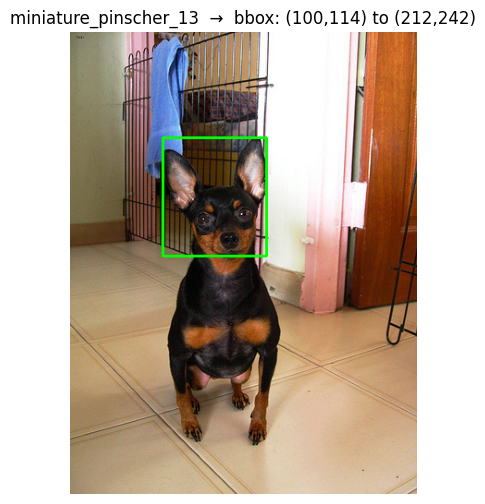

In [70]:
# plot a random image with its trimap and bounding box
base_name = random.choice(list(image_basenames & xml_basenames))
img_path = os.path.join(DATA_DIR, 'images', f"{base_name}.jpg")
xml_path = os.path.join(DATA_DIR, 'groundtruth', 'annotations', 'xmls', f"{base_name}.xml")

img = cv2.imread(img_path)

tree = ET.parse(xml_path)
root = tree.getroot()
bnd  = root.find('object').find('bndbox')
xmin = int(bnd.find('xmin').text)
ymin = int(bnd.find('ymin').text)
xmax = int(bnd.find('xmax').text)
ymax = int(bnd.find('ymax').text)

cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(img_rgb)
plt.axis('off')
plt.title(f"{base_name}  →  bbox: ({xmin},{ymin}) to ({xmax},{ymax})")
plt.show()

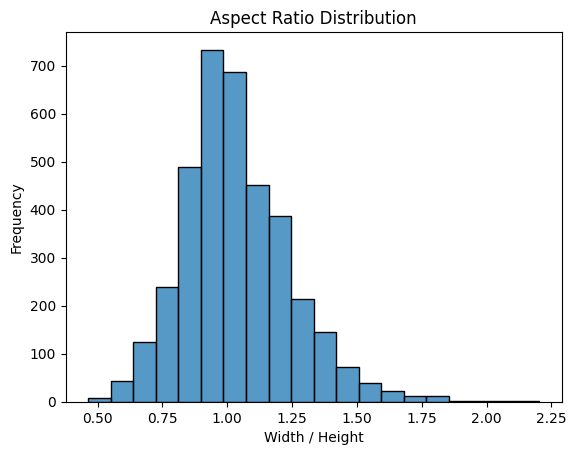

In [71]:
bbox_sizes = []
aspect_ratios = []

for xml_path in xml_paths:
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bnd = root.find('object').find('bndbox')
    xmin = int(bnd.find('xmin').text)
    ymin = int(bnd.find('ymin').text)
    xmax = int(bnd.find('xmax').text)
    ymax = int(bnd.find('ymax').text)
    
    width = xmax - xmin
    height = ymax - ymin
    bbox_sizes.append((width, height))
    aspect_ratios.append(width / height)

bbox_df = pd.DataFrame(bbox_sizes, columns=['width', 'height'])
bbox_df['aspect_ratio'] = aspect_ratios

sns.histplot(bbox_df['aspect_ratio'], bins=20)
plt.title("Aspect Ratio Distribution")
plt.xlabel("Width / Height")
plt.ylabel("Frequency")
plt.show()

In [72]:
def rotate_image_and_bbox(image, bbox, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(image, M, (w, h))

    x1, y1, x2, y2 = bbox
    points = np.array([
        [x1, y1],
        [x2, y1],
        [x2, y2],
        [x1, y2]
    ])
    ones = np.ones((points.shape[0], 1))
    points_ones = np.hstack([points, ones])
    transformed = M @ points_ones.T
    x_coords = transformed[0, :]
    y_coords = transformed[1, :]

    new_bbox = [int(x_coords.min()), int(y_coords.min()), int(x_coords.max()), int(y_coords.max())]
    return rotated_img, new_bbox

def horizontal_flip_image_and_bbox(image, bbox):
    flipped_img = cv2.flip(image, 1)
    h, w = image.shape[:2]
    x1, y1, x2, y2 = bbox
    new_bbox = [w - x2, y1, w - x1, y2]
    return flipped_img, new_bbox


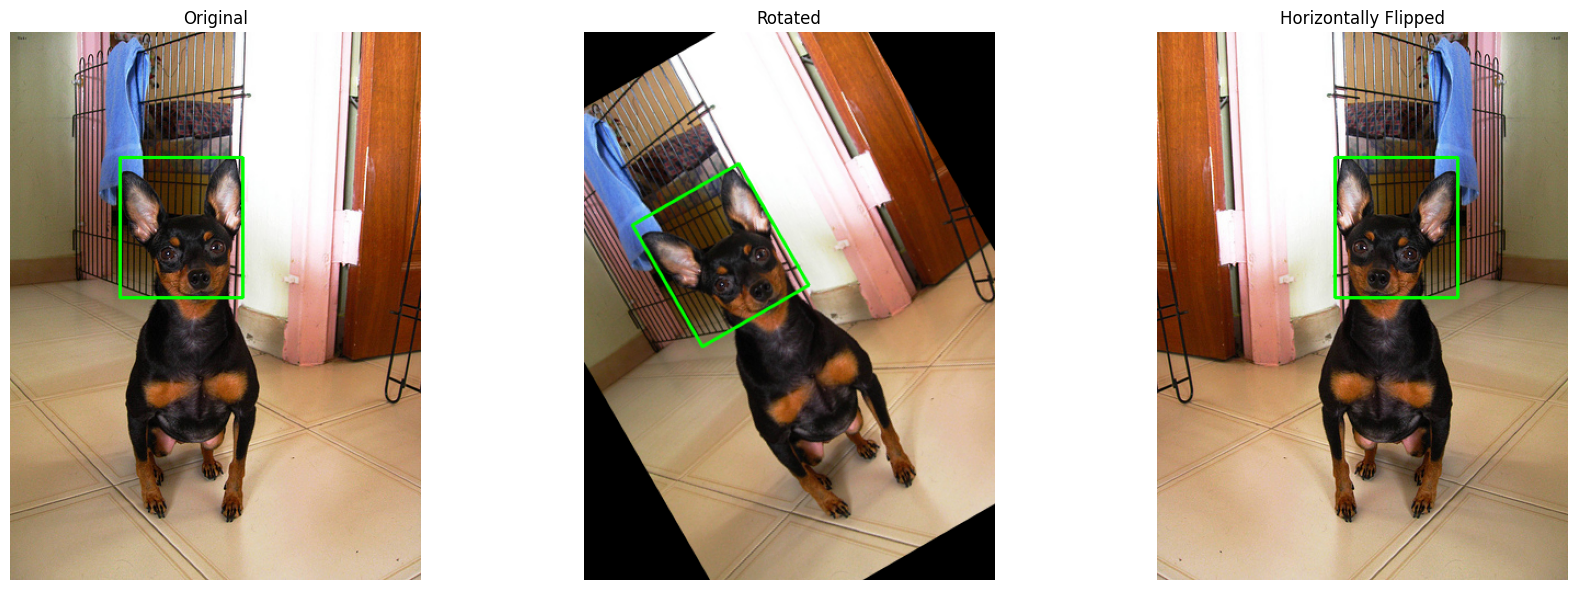

In [73]:
angle = 30
rotated_img, _ = rotate_image_and_bbox(img.copy(), (xmin, ymin, xmax, ymax), angle)
flipped_img, _ = horizontal_flip_image_and_bbox(img.copy(), (xmin, ymin, xmax, ymax))

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
plt.title("Rotated")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(flipped_img, cv2.COLOR_BGR2RGB))
plt.title("Horizontally Flipped")
plt.axis('off')

plt.tight_layout()
plt.show()

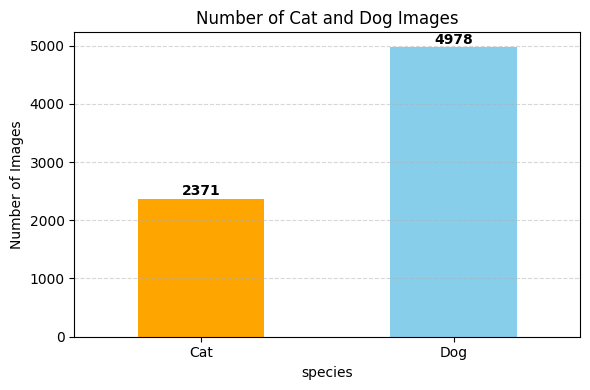

In [74]:
# Skip the first 6 header lines
with open(LIST_PATH, 'r') as f:
    lines = f.readlines()[6:]

# Parse lines
data = []
for line in lines:
    parts = line.strip().split()
    if len(parts) >= 4:
        image = parts[0]
        class_id = int(parts[1])
        species_id = int(parts[2])
        breed_id = int(parts[3])
        species = "Cat" if species_id == 1 else "Dog"
        data.append({
            'image': image,
            'class_id': class_id,
            'species': species,
            'breed_id': breed_id
        })

df = pd.DataFrame(data)

# Count species
species_counts = df['species'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(6, 4))
ax = species_counts.plot(kind='bar', color=['orange', 'skyblue'])

# Add value labels on top of bars
for idx, val in enumerate(species_counts):
    ax.text(idx, val + 5, str(val), ha='center', va='bottom', fontweight='bold')

plt.title("Number of Cat and Dog Images")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [75]:
list_df = list_df[list_df['species'] == 2].copy()
list_df['has_xml'] = list_df['image'].apply(lambda n: os.path.exists(os.path.join(XML_DIR, f"{n}.xml")))
list_df = list_df[list_df['has_xml']].reset_index(drop=True)

print(f"Verwendbare Hunde-Bilder: {len(list_df)} (alle haben jetzt XML)")

Verwendbare Hunde-Bilder: 2490 (alle haben jetzt XML)


In [76]:
train_df, tmp_df = train_test_split(list_df, test_size=0.3, stratify=list_df['class_id'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['class_id'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 1743, Val: 373, Test: 374


In [77]:
class OxfordPetsDetectionDataset(Dataset):
    def __init__(self, df, img_dir, xml_dir, transforms=None):
        self.df = df
        self.img_dir = img_dir
        self.xml_dir = xml_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        name = row['image']
        img = Image.open(os.path.join(self.img_dir, f"{name}.jpg")).convert("RGB")

        # read XML file
        xml_path = os.path.join(self.xml_dir, f"{name}.xml")
        tree = ET.parse(xml_path)
        b = tree.find('object').find('bndbox')
        xmin, ymin, xmax, ymax = [int(b.find(tag).text) for tag in ('xmin','ymin','xmax','ymax')]

        # build target dict
        boxes = torch.tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
        labels = torch.tensor([1], dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = torch.tensor((xmax - xmin) * (ymax - ymin), dtype=torch.float32)   # **hier als Tensor**
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': image_id,
            'area': area,      
            'iscrowd': iscrowd
        }

        if self.transforms:
            img = self.transforms(img)
        return img, target

In [78]:
def collate_fn(batch):
    return tuple(zip(*batch))


def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_ds = OxfordPetsDetectionDataset(train_df, IMG_DIR, XML_DIR, transforms=transform)
val_ds   = OxfordPetsDetectionDataset(val_df,   IMG_DIR, XML_DIR, transforms=transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, collate_fn=collate_fn)

# model initialization
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_classes=2)  # 1 Klasse Hund + Hintergrund
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-4)

# training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Avg Loss: {avg_loss:.4f}")

print("Training abgeschlossen.")


/Users/oliverpejic/Documents/Classes/dlbs/dlbs-mc-oliver-fabian/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/oliverpejic/Documents/Classes/dlbs/dlbs-mc-oliver-fabian/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 